# SQL-запросы

In [1]:
# импорт библиотек
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sqlalchemy import create_engine 

## Конфигурация для подключения к базе данных 

In [2]:
# подключение к базе данных
# параметры для подключения к БД скрыты в соответствии с офертой Яндекс.Практикума
db_config = {
    'user': '', # имя пользователя
    'pwd': '', # пароль
    'host': '',
    'port':  # порт подключения
    'db': '' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [3]:
# создание подключения
engine = create_engine(connection_string) 

## Задание 1

Вывести общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортировать по убыванию общего количества просмотров.

In [4]:
query = '''
SELECT 
    DATE_TRUNC('MONTH', creation_date) AS month_date,
    SUM(views_count) AS total_views
FROM stackoverflow.posts
WHERE DATE_TRUNC('MONTH', creation_date) BETWEEN '2008-01-01' AND '2008-12-01'
GROUP BY DATE_TRUNC('MONTH', creation_date)
ORDER BY SUM(views_count) DESC
'''
sample_df = pd.read_sql_query(query, con=engine)

In [5]:
sample_df

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


**Вопрос: Отличаются ли данные за разные месяцы? С чем могут быть связаны отличия?**

**Анализ таблицы:** в июле-августе 2008 года была запущена самая первая версия проекта StackOverflow, именно поэтому число просмотров постов наименьшее, в сравнении с остальными месяцами года.
Сентябрь 2008 года считается официальной датой запуска StackOverflow. Одной из главных особенностей проекта считается то, что разработчики не должны платить за доступ к информации, оставленной другими разработчиками. Именно в первый месяц официального запуска и предоставления публичного доступа самое большое число просмотров постов. 

# Задание 2

Вывести имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывать. Для каждого имени пользователя вывести количество уникальных значений `user_id`. Отсортировать результат по полю с именами в лексикографическом порядке.

In [6]:
query = '''
SELECT
    u.display_name, 
    COUNT(DISTINCT p.user_id)
FROM stackoverflow.users AS u
JOIN stackoverflow.posts AS p ON p.user_id = u.id
JOIN stackoverflow.post_types AS pt ON pt.id = p.post_type_id
WHERE pt.type = 'Answer' 
      AND u.creation_date <= p.creation_date AND p.creation_date <= u.creation_date + INTERVAL '1 months'
GROUP BY u.display_name
HAVING COUNT(p.user_id) > 100
ORDER BY u.display_name
'''
sample_df = pd.read_sql_query(query, con=engine)

In [7]:
sample_df

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8
...,...,...
71,leppie,1
72,lomaxx,1
73,mattlant,1
74,paxdiablo,1


**Вопрос: Какие аномалии наблюдаются в данных? О чём они говорят?**

In [8]:
# выведу строки, где количество уникального id пользователя встречается больше одного раза
sample_df.query('count > 1')

,display_name,count
4,Alan,8
7,Brian,15
10,Chris,29
12,Craig,10
14,Dan,21
21,Greg,12
25,Jim,7
26,Joe,9
33,Josh,16
34,Keith,5


**Анализ таблицы:** аномалия в данных заключается в том, что есть 19 никнеймов, которые не идентифицируют конкретного пользователя. Например, имя Chris имеют 29 уникальных пользователей, имя Dan - 21 пользователь и тд.

# Задание 3

Вывести количество постов за 2008 год по месяцам. Отобрать посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортировать таблицу по значению месяца по убыванию.

In [9]:
query = '''
SELECT 
    DATE_TRUNC('MONTH', p.creation_date) AS month,
    COUNT(p.id)
FROM stackoverflow.posts as p
WHERE p.user_id IN (SELECT DISTINCT u.id
                    FROM stackoverflow.posts AS p
                    JOIN stackoverflow.users AS u ON u.id = p.user_id
                    WHERE DATE(DATE_TRUNC('MONTH', u.creation_date)) = '2008-09-01' AND
                    DATE(DATE_TRUNC('MONTH', p.creation_date)) = '2008-12-01')
GROUP BY month
ORDER BY month DESC
'''
sample_df = pd.read_sql_query(query, con=engine)

In [10]:
sample_df

,month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


**Вопрос: есть ли аномалии в данных?**

**Анализ таблицы:** да, есть аномалии: в запросе присутствуют 32 поста, оставленные пользователями в августе 2008, при том, что дата регистрации пользователя на сайте - сентябрь 2008 года. Это могут быть ошибки в базе данных, или влияет смещение часовых поясов, либо можно было оставлять сообщения до регистрации.

# Задание 4

Используя данные о постах, вывести несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

In [11]:
query = '''
SELECT 
    user_id, 
    creation_date, views_count, 
    SUM(views_count) OVER(PARTITION BY user_id ORDER BY creation_date) AS cumulative_count
FROM stackoverflow.posts
ORDER BY user_id, creation_date
'''
sample_df = pd.read_sql_query(query, con=engine)

In [12]:
sample_df

,user_id,creation_date,views_count,cumulative_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


# Задание 5

Найти среднее количество постов пользователей в день за август 2008 года. Отобрать данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывать. 

Отсортировать результат по возрастанию среднего количества постов. Значения можно не округлять.

In [13]:
query = '''
WITH count_posts AS
    (SELECT user_id, COUNT(id) AS count_id, DATE(creation_date)
    FROM stackoverflow.posts
    WHERE DATE(creation_date) BETWEEN '2008-08-01' AND '2008-08-31'
    AND user_id IN (SELECT user_id
                    FROM stackoverflow.posts
                    WHERE DATE(creation_date) BETWEEN '2008-08-01' AND '2008-08-31' 
                    GROUP BY user_id
                    HAVING COUNT(id) > 120)
    GROUP BY DATE(creation_date), user_id)
SELECT user_id, AVG(count_id)
FROM count_posts
WHERE count_id > 0
GROUP BY user_id
ORDER BY AVG(count_id)
'''
sample_df = pd.read_sql_query(query, con=engine)

In [14]:
sample_df.head(10)

,user_id,avg
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отобрать дни, в которые он или она опубликовали хотя бы один пост.

In [15]:
query = '''
WITH count_days AS
    (SELECT COUNT(DISTINCT DATE(creation_date)) AS days, user_id
    FROM stackoverflow.posts
    WHERE DATE(creation_date) BETWEEN '2008-12-01' AND '2008-12-07'
    GROUP BY user_id)
SELECT ROUND(AVG(days))
FROM count_days
'''
sample_df = pd.read_sql_query(query, con=engine)

In [16]:
sample_df

,round
0,2.0


**Вывод:** в среднем, два раза за неделю пользователи публиковали посты в период с 1 по 7 декабря 2008 года.

# Задание 7

Вывести историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортировать вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавить в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, указать `NULL`.

In [17]:
query = '''
SELECT user_id, creation_date,
to_char(LAG(creation_date, 2) OVER(PARTITION BY user_id ORDER BY creation_date), 'Month')
FROM stackoverflow.posts
'''
sample_df = pd.read_sql_query(query, con=engine)

In [18]:
sample_df

,user_id,creation_date,to_char
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


# Задание 8

Рассчитать аналог Retention Rate по месяцам для пользователей StackOverflow. Объединить пользователей в когорты по месяцу их первого поста. Возвращение определить по наличию поста в текущем месяце. 

In [19]:
query = '''
WITH profile AS
(SELECT DISTINCT user_id, 
                 DATE_TRUNC('MONTH', creation_date) AS cohort_dt,
                 ROW_NUMBER(*) OVER (PARTITION BY user_id ORDER BY creation_date) AS rn
 FROM stackoverflow.posts),
session AS
(SELECT DISTINCT user_id, 
        DATE_TRUNC('MONTH', creation_date) AS session_date
 FROM stackoverflow.posts
 ORDER BY session_date
)
SELECT *,
ROUND(users_cnt::numeric * 100.0 / cohort_users_cnt::numeric, 2) AS retention_rate
FROM
(SELECT p.cohort_dt,
        s.session_date,
        COUNT(s.user_id) AS users_cnt,
        FIRST_VALUE(COUNT(p.user_id)) OVER (PARTITION BY p.cohort_dt ORDER BY s.session_date) AS cohort_users_cnt
 FROM profile AS p
 JOIN session AS s ON p.user_id = s.user_id
 WHERE p.rn = 1
 GROUP BY p.cohort_dt,
          s.session_date
 ORDER BY p.cohort_dt,
          s.session_date) AS preprocessed
'''

sample_df = pd.read_sql_query(query, con=engine)

In [20]:
sample_df.head(10)

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


**Построить тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулировать гипотезы о возможных причинах.**

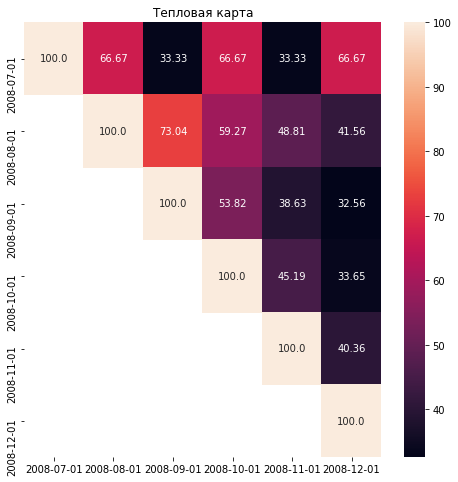

In [21]:
# тепловая карта Retention Rate
retention = sample_df.pivot('cohort_dt', 'session_date', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

plt.figure(figsize=(8, 8))
sns.heatmap(retention,
            annot=True,
            fmt='')
plt.title('Тепловая карта')
plt.show() 

**Анализ графика:**
- для когорт, зарегистрированных с августа по сентябрь, Retention Rate с каждым месяцем уменьшается, а для когорты пользователей с датой регистрации июль 2008 года Retention Rate чередуется как пик/спад: 2/3 пользователей публиковали посты в августе; 1/3 - в сентябре; 2/3 - в октябре и тд.;
- самая активная когорта по числу публикаций постов - от августа 2008 года.

# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразить таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлить значение процента до двух знаков после запятой.

In [22]:
query = '''
WITH total_posts_month AS
    (SELECT CAST(EXTRACT(MONTH FROM CAST(creation_date AS TIMESTAMP)) AS integer),
            COUNT(id) AS posts_count
     FROM stackoverflow.posts
     WHERE EXTRACT(MONTH FROM CAST (creation_date AS TIMESTAMP)) BETWEEN 9 AND 12
     GROUP BY EXTRACT(MONTH FROM CAST(creation_date AS TIMESTAMP)))
SELECT *,
        ROUND((CAST(posts_count AS numeric) / LAG(posts_count) OVER (ORDER BY date_part) -1) * 100, 2) AS percentage
FROM total_posts_month
'''
sample_df = pd.read_sql_query(query, con=engine)

In [23]:
sample_df

,date_part,posts_count,percentage
0,9,70371,NaN
1,10,63102,-10.33
2,11,46975,-25.56
3,12,44592,-5.07


**Построить круговую диаграмму с количеством постов по месяцам.**

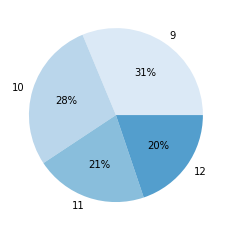

In [24]:
# круговая диаграмма с количеством постов по месяцам
colors = sns.color_palette('Blues')[0:4]
plt.pie(sample_df['posts_count'], labels = sample_df['date_part'], colors=colors, autopct='%.0f%%')
plt.show()

# Задание 10

Выгрузить данные активности пользователя, который опубликовал больше всего постов за всё время. Вывести данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

In [25]:
query = '''
SELECT DISTINCT CAST(EXTRACT(WEEK FROM CAST(creation_date AS TIMESTAMP)) AS integer) AS week_creation, 
       MAX(creation_date) OVER(PARTITION BY EXTRACT(WEEK FROM CAST(creation_date AS TIMESTAMP))) AS creation_date
FROM stackoverflow.posts
WHERE user_id IN (SELECT user_id
                  FROM stackoverflow.posts
                  GROUP BY user_id
                  ORDER BY COUNT(id) DESC
                  LIMIT 1) AND DATE(creation_date) BETWEEN '2008-10-01' AND '2008-10-31'                  
'''
sample_df = pd.read_sql_query(query, con=engine)

In [26]:
sample_df

,week_creation,creation_date
0,40,2008-10-05 09:00:58
1,41,2008-10-12 21:22:23
2,42,2008-10-19 06:49:30
3,43,2008-10-26 21:44:36
4,44,2008-10-31 22:16:01
